# Random Forest for Identifying Alcohol Abuse #

** Submitted as part of Machine Learning for Data Analysis by Wesleyan University **
** Author: Oliver Morris **
** Date: 20 March 2016 **

The below analysis will show the code and describe the context of a random forest constructed in python which identifies whether a person has declared the onset of alcohol abuse.

This uses the NESARC data, which is a standard data set for the Wesleyan Univeristy course in Machine Learning & Data Analysis at Coursera. 

FYI. This blog entry was published using Jupyter, which is designed for sharing reproducible data science in python. The code was prepared in Visual Studio 2015 Community Edition on Windows 10 with the Anaconda Python Environment and an IPython interactive window installed.


## Dependencies ##

The packages used are the same as for the example code, however, pandasql which is sql-lite for python, has also been introduced. This is used in the cleaning of the NESARC data into a format usable by the decision tree code.

The scikit-learn (aka sklearn) package is used for the random forest tool

In [1]:
#Standard data packages

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import os

#For building a random forest

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

#For calculating importance of each predictor (aka feature)
    
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier

#We'll use SQL for data cleaning

from pandasql import sqldf

## The NESARC Data ##

The NESARC data set is large, over 40,000 rows and 3,000 columns, 258Mb. Reading the data into a pandas object is straightforward, but takes some time.

In [3]:
#Set working directory to course folder

os.chdir("C:/Users/Oliver/Documents/0_OM/Training/WesleyanPython/0_Data")

#Load the Alchohol Abuse Dataset, NESARC, remove 'na' records.

import warnings
warnings.filterwarnings('ignore')
NESARC_data = pd.read_csv("nesarc_pds.csv")
data_clean = NESARC_data.dropna()
del NESARC_data

#Display size of the data

print('OUTPUT:\n')
print('NESARC dataset size (rows, columns) =',data_clean.shape)

OUTPUT:

NESARC dataset size (rows, columns) = (43093, 3008)


## Get Predictors & Target from Dataset ##

There are thousands of predictors in the NESARC data list, the following were selected as predictors for the decision tree simply because they appeared reasonable. Note the target is extracted at the same time, this assists with data cleaning in a later step.

In [4]:
#Get predictors from dataset

target_and_predictors_fullset = data_clean[[
# TARGET
 'S2BQ3A', #AGE AT ONSET OF ALCOHOL ABUSE

# PREDICTORS
 'S1Q1E',  #ORIGIN OR DESCENT
 'S1Q2C1', #RAISED BY ADOPTIVE PARENTS BEFORE AGE 18
 'S1Q2B',  #BIOLOGICAL FATHER EVER LIVE IN HOUSEHOLD BEFORE RESPONDENT WAS 18
 'S1Q2C4', #RAISED IN AN INSTITUTION BEFORE AGE 18
 'S1Q2D',  #DID BIOLOGICAL OR ADOPTIVE PARENTS GET DIVORCED OR PERMANENTLY STOP LIVING TOGETHER BEFORE RESPONDENT WAS 18
 'S1Q2K',  #DID BIOLOGICAL OR ADOPTIVE PARENT DIE BEFORE RESPONDENT WAS 18
 'S1Q2L',  #AGE AT DEATH OF BIOLOGICAL OR ADOPTIVE PARENT
 'S1Q4A',  #AGE AT FIRST MARRIAGE
 'S1Q5A',  #CHILDREN EVER HAD, INCLUDING ADOPTIVE, STEP AND FOSTER CHILDREN
 'S1Q6A',  #HIGHEST GRADE OR YEAR OF SCHOOL COMPLETED
 'MARITAL',#CURRENT MARITAL STATUS
 'AGE',    #AGE
 'SEX'     #SEX
 ]]

## Data Cleaning ##

The NESARC data has lots of blanks, many of which are valid and do not mean 'unknown'. The data can be made useful by replacing blanks with another integer, which was chosen following review of the NESARC codebook.

The target needs to be simplified into a yes/no outcome, yet the selected field is "Age at onset of alohol abuse". This can be any integer from 1-99, or blank if there is no abuse. So, the data is simplified to 1 if there is any age at which alcohol absue developed, else 0.

Finally, the records where these predictors are 'unknown', usually represented by a '9', are removed as 'unknowns' simply confuse the decision tree.

In [5]:
#Clean predictors

query = """
SELECT
     CAST(LTRIM(S1Q1E) AS INTEGER) AS S1Q1E
     --origin or descent: 1-98. 99=unknown

    ,CASE WHEN LTRIM(S1Q2C1) = '' THEN 2 ELSE CAST(LTRIM(S1Q2C1) AS INTEGER) END AS S1Q2C1
     --raised by adoptive parents before age 18: 1=Y, 2=N, 9=unknown, BL=2

    ,CASE WHEN LTRIM(S1Q2B)  = '' THEN 0 ELSE CAST(LTRIM(S1Q2B)  AS INTEGER) END AS S1Q2B
     --biological father ever live in household before respondent was 18: 1=Y, 2=N, 9=unknown, BL=2

    ,CASE WHEN LTRIM(S1Q2C4) = '' THEN 2 ELSE CAST(LTRIM(S1Q2C4) AS INTEGER) END AS S1Q2C4
     --raised in an institution before age 18: 1=Y, 2=N, 9=unknown, BL=2

    ,CASE WHEN LTRIM(S1Q2D) = '' THEN 2 ELSE CAST(LTRIM(S1Q2D) AS INTEGER) END AS S1Q2D 
     --parental divorce before 18, 1=Yes, 2=No, 9=Unknown. Default for blank is No (2)
     
    ,CASE WHEN LTRIM(S1Q2K) = '' THEN 2 ELSE CAST(LTRIM(S1Q2K) AS INTEGER) END AS S1Q2K
     --parent death before 18, 1=Yes, 2=No, 9=Unknown. Default for blank is No (2)
         
    ,CASE WHEN LTRIM(S1Q2L)  = '' THEN 99 ELSE CAST(LTRIM(S1Q2L)  AS INTEGER) END AS S1Q2L
     --age at death of biological or adoptive parent: 1-99, 99=Unknown, BL=99. Default for blank is unknown (99)

    ,CASE WHEN LTRIM(S1Q4A) = '' THEN 99 ELSE CAST(LTRIM(S1Q4A) AS INTEGER) END AS S1Q4A
     --age at first marriage: 1-99, 99=Unknown, BL=99. Default for blank is unknown (99)

    ,CAST(LTRIM(S1Q5A) AS INTEGER) AS S1Q5A  
     --children ever had, including adoptive, step and foster children: 0-14, 99=unknown

    ,CAST(LTRIM(S1Q6A) AS INTEGER) AS S1Q6A
     --highest grade or year of school completed: 1 - 14

    ,CAST(LTRIM(MARITAL) AS INTEGER) AS MARITAL
     --current marital status: 1 = married, 2 =cohabiting, 3=widowed, 4=divorced, 5=separated, 6=single

    ,CAST(LTRIM(AGE) AS INTEGER) AS AGE

    ,CAST(LTRIM(SEX) AS INTEGER) AS SEX
FROM
    target_and_predictors_fullset
WHERE
    --Remove the 'unknown' values, as these confuse the decision trees
    (S1Q1E <> 99) AND (S1Q2C1 <> 9) AND (S1Q2B <>  9) AND (S1Q2C4 <> 9) AND (S1Q2D <> 99) AND 
    (S1Q2K <> 9 ) AND (S1Q2L <> 99) AND (S1Q4A <> 99) AND (LTRIM(S1Q4A) <> '') AND (S1Q5A <> 99) 
"""
predictors = sqldf(query, locals())

#Get Targets

query = """
SELECT
    CASE WHEN LTRIM(S2BQ3A) = '' THEN 0 ELSE 1 END AS S2BQ3A
    --S2BQ3A = AGE AT ONSET OF ALCOHOL ABUSE
    --i.e. integer value up to 99, but blank = no alcohol abuse
    --We convert this to a classification outcome by saying any age = 1, but blank = 0
FROM
    target_and_predictors_fullset
WHERE
     --Remove the 'unknown' values, as these confuse the decision trees
    (S1Q1E <> 99) AND (S1Q2C1 <> 9) AND (S1Q2B <>  9) AND (S1Q2C4 <> 9) AND (S1Q2D <> 99) AND 
    (S1Q2K <> 9 ) AND (S1Q2L <> 99) AND (S1Q4A <> 99) AND (LTRIM(S1Q4A) <> '') AND (S1Q5A <> 99)
"""
targets = sqldf(query, locals())

#now that we have predictors and target we can save memory by clearing the unused data frames
del target_and_predictors_fullset
del data_clean


## Model Training ##

The data is split into training / test set, with 40% retained for test. Then the random forest can be assembled, using RandomForestClassifier from sklearn. 25 trees are permitted in the forest. 

In [7]:
#Create train / test split

pred_train, pred_test, tar_train, tar_test  = train_test_split(predictors, targets, test_size=.4)

#Display size of each set

print('OUTPUT:\n')
print('pred_train shape =',pred_train.shape)
print('pred_test shape =',pred_test.shape)
print('tar_train shape =',tar_train.shape)
print('tar_test shape =',tar_test.shape)

#Build model on training data

from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=25)
classifier=classifier.fit(pred_train,tar_train.S2BQ3A.values)


OUTPUT:

pred_train shape = (18219, 13)
pred_test shape = (12146, 13)
tar_train shape = (18219, 1)
tar_test shape = (12146, 1)


## Model Results ##

Having constructed the model, the overall confusion matrix and accuracy can be displayed. This forest leads to an accuracy of 72.6% over 12,000+ test observations. It is tempting to see how this accuracy was arrived at. But, upon attempting to view the first tree in the forest, we get a model which is far too complex to understand, thousands of branches.

The only way to interpret the model is to calculate how important each individual predictor is to the overall model accuracy. The subsequent code cell does these calculations.



confusion matrix:
  [[7946 1003]
 [2352  845]]


accuracy score:
  0.723777375268


Diagram of First Tree in the Forest:

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.206363 to fit



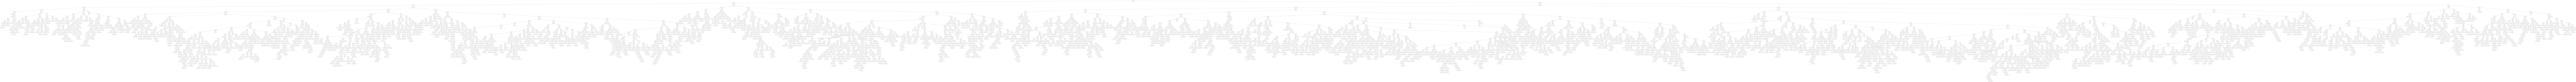

In [8]:
#Get predictions for the test data set

predictions=classifier.predict(pred_test)

#Display accuracy results

print('\n')
print('confusion matrix:\n ',sklearn.metrics.confusion_matrix(tar_test.S2BQ3A.values, predictions))
print('\n')
print('accuracy score:\n ',sklearn.metrics.accuracy_score(tar_test.S2BQ3A.values, predictions))

#Display the first tree in the forest

print('\n')
print('Diagram of First Tree in the Forest:\n')
from sklearn import tree
from io import StringIO
from IPython.display import Image

out = StringIO()
tree.export_graphviz(classifier.estimators_[0], out_file=out)

import pydotplus
graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

## Importance of Predictors to Identifying Alcohol Abuse ##

The 13 predictors of alchohol abuse do not have the same relevance to the model. Some, such as Age(yrs) and origin/descent, are highly influential, others, such as who raised the person, are not. It is difficult to say very much more. This illustrate the problem with random forests, besides simple importance ratings it is very difficult to interpret the model in roder to gain insights to the data. The model is a statistical result, it does not convey insight as to why each predictor has the importance ratings listed below.

In [9]:
#Create a description of each predictor

predictors_names = ['origin or descent',
'raised by adoptive parents before age 18',
'biological father ever live in household before respondent was 18',
'raised in an institution before age 18',
'parental divorce before 18',
'parent death before 18',
'age at death of biological or adoptive parent',
'age at first marriage',
'children ever had',
'highest grade or year of school completed',
'current marital status',
'Age(yrs)',
'Sex(M/F)']

#Fit an 'Extra Trees' model to the data
#This increases the forest by one tree at a time, so we can see how important each individual predictor is

model = ExtraTreesClassifier()
model.fit(pred_train,tar_train.S2BQ3A.values)

#assign the resulting importance List predictor importance

output=pd.DataFrame(predictors.columns.values.tolist())
output.columns=['Predictor']
output['Description']=predictors_names
output['Importance']=model.feature_importances_
print('OUTPUT:\n')
output.sort_values(by='Importance', ascending=False)


OUTPUT:



,Predictor,Description,Importance
11,AGE,Age(yrs),0.236781
0,S1Q1E,origin or descent,0.186965
7,S1Q4A,age at first marriage,0.185372
8,S1Q5A,children ever had,0.120223
9,S1Q6A,highest grade or year of school completed,0.101868
12,SEX,Sex(M/F),0.077461
10,MARITAL,current marital status,0.030490
2,S1Q2B,biological father ever live in household befor...,0.019937
6,S1Q2L,age at death of biological or adoptive parent,0.018002
4,S1Q2D,parental divorce before 18,0.015810


## Improvement in Accuracy With Increasing Number of Trees ##

The first tree gives us an accuracy of 67%, the 25th gives 73%. So there is some improvement for additional trees, but this quickly tails off and we have achieved nearly all the improvement with just 8 trees.

The following chart shows how accuracy (y-axis) improves with the number of trees (x-axis).

<IPython.core.display.Javascript object>


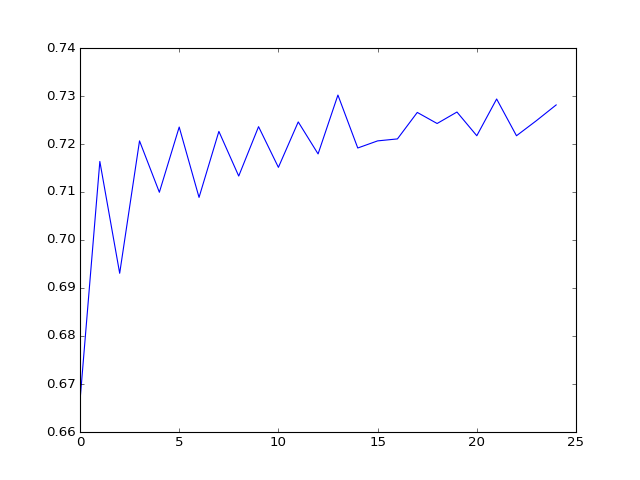

In [12]:
#Display a chart of how the number of trees in the forest improves accuracy

trees=range(25)
accuracy=np.zeros(25)
for idx in range(len(trees)):
   classifier=RandomForestClassifier(n_estimators=idx + 1)
   classifier=classifier.fit(pred_train,tar_train.S2BQ3A.values)
   predictions=classifier.predict(pred_test)
   accuracy[idx]=sklearn.metrics.accuracy_score(tar_test.S2BQ3A.values, predictions)

#Plot the above table

%matplotlib notebook
import matplotlib.pyplot as plt
plt.cla()
plt.plot(trees, accuracy)
  
#If you want to save to file instead of display in interactive window

#plt.ioff()
#plt.plot(trees, accuracy)
#os.chdir("C:/Users/Oliver/Documents/0_OM/Training/WesleyanPython/2_RandomForests")
#plt.savefig('NESARC_FOREST_IMAGE.png')